In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import datetime
import shapely.geometry

from salishsea_tools import viz_tools

DFO data from 2013 - Mar 2020

PSF data from 2015 - 2017

PUG data from 2015 - 2018

ONC data from 2014 - 2022 

Ferry data from 2013 - 2022

CIOOS data from 2007 - 2023

In [2]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

color_spring = '#7ABB00'
color_summer = '#FFBF00'
color_fall = '#FF6F00'
color_winter = '#00C6C9'

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [5]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
bathy2 = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')

In [6]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [7]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [8]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [9]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [10]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [11]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [12]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean()

In [13]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
    
    return temp1_nohook

In [14]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series lime green.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('limegreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [15]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [16]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

In [17]:
def plot_poly(ax, poly, color):
    x,y = poly.exterior.xy
    ax.plot(x,y,color=color)

In [18]:
def make_poly4corn(y0, y1, x0, x1):
    return shapely.geometry.Polygon([(x0, y0), (x1, y0), (x1, y1), (x0, y1)])

## Me change

In [19]:
import salishsea_tools.river_202108 as rivers
import salishsea_tools.river_201702 as rivers2

In [20]:
def river_box(w_shed, r_call, box_side):  #TODO: change either box location or change box to circle
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 897-box_side*2
        river_range[1] = 897

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

In [21]:
def river_point(w_shed, r_call, old):
    if old == False:
        idx = rivers.prop_dict[w_shed][r_call]['i']
        jdx = rivers.prop_dict[w_shed][r_call]['j']
        return idx, jdx
    elif old == True:
        idx = rivers2.prop_dict[w_shed][r_call]['i']
        jdx = rivers2.prop_dict[w_shed][r_call]['j']
        return idx, jdx

In [22]:
river_dict = {
    'Nooksack' : {'wshed' : "fraser", 'call' : "Nooksack"},
    'Skagit' : {'wshed' : "skagit", 'call' : "Skagit1"},
    'Snohomish' : {'wshed' : 'skagit', 'call' : "SnohomishAllenQuilceda"},
    'Nisqually' : {'wshed' : "puget", 'call' : "NisquallyMcAllister"},
    'Elwha' : {'wshed' : 'jdf', 'call' : 'Elwha'},
    'Cowichan' : {'wshed' : "evi_s", 'call' : "Cowichan1"},
    'Nanaimo' : {'wshed' : "evi_s", 'call' : "Nanaimo1"},
    'Puntledge' : {'wshed' : "evi_s", 'call' : "Puntledge"},
    'Salmon' : {'wshed' : "evi_n", 'call' : "SalmonSayward"},
    'Homathko' : {'wshed' : "bute", 'call' : "Homathko"},
    'Squamish' : {'wshed' : "howe", 'call' : "Squamish"},
}

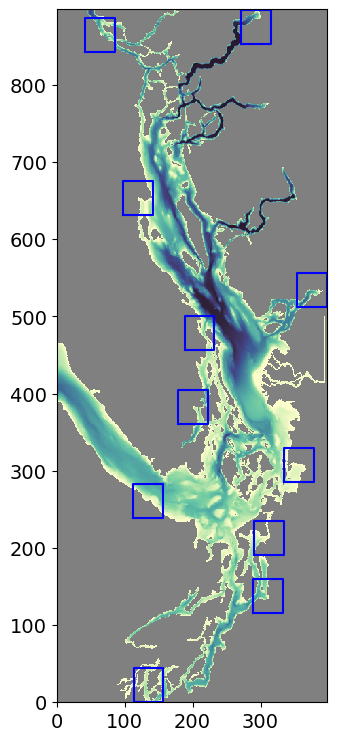

In [23]:
box_size = 22

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax, Nooksack, 'b')
Nooksack_E = make_poly4corn(290, 312, 335, 357)
Nooksack_W = make_poly4corn(290, 312, 313, 335)
# plot_poly(ax, Nooksack_E, 'm')
# plot_poly(ax, Nooksack_W, 'm')

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax, Skagit, 'b')
Skagit_NE = make_poly4corn(205, 227, 300, 322)
Skagit_SE = make_poly4corn(180, 202, 295, 317)
Skagit_SW = make_poly4corn(190, 212, 272, 294)
# plot_poly(ax, Skagit_NE, 'm')
# plot_poly(ax, Skagit_SE, 'm')
# plot_poly(ax, Skagit_SW, 'm')

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax, Snohomish, 'b')
Snohomish_NE = make_poly4corn(145, 167, 290, 312)
Snohomish_SE = make_poly4corn(123, 144, 291, 313)
Snohomish_SW = make_poly4corn(123, 144, 268, 290)
# plot_poly(ax, Snohomish_NE, 'm')
# plot_poly(ax, Snohomish_SE, 'm')
# plot_poly(ax, Snohomish_SW, 'm')

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax, Nisqually, 'b')
Nisqually_CS = make_poly4corn(1, 23, 120, 142)
Nisqually_CN = make_poly4corn(24, 46, 120, 142)
Nisqually_SW = make_poly4corn(1, 23, 97, 119)
Nisqually_E = make_poly4corn(5, 35, 143, 165)
# plot_poly(ax, Nisqually_CS, 'm')
# plot_poly(ax, Nisqually_CN, 'm')
# plot_poly(ax, Nisqually_SW, 'm')
# plot_poly(ax, Nisqually_E, 'm')

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax, Elwha, 'b')
Elwha_WC = shapely.geometry.Polygon([(105, 280), (110, 290), (125, 285), (123, 275)])
Elwha_WS = shapely.geometry.Polygon([(115, 290), (120, 303), (135, 295), (143, 288)])
Elwha_EC = make_poly4corn(245, 255, 157, 179)
Elwha_ES = make_poly4corn(265, 285, 157, 179)
# plot_poly(ax, Elwha_WC, 'm')
# plot_poly(ax, Elwha_WS, 'm')
# plot_poly(ax, Elwha_EC, 'm')
# plot_poly(ax, Elwha_ES, 'm')

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax, Cowichan, 'b')
Cowichan_CN = shapely.geometry.Polygon([(209, 379), (209, 420), (235, 410), (214, 375)])  # because of how the dye looks in March
Cowichan_CC = shapely.geometry.Polygon([(200, 386), (222, 368), (200, 363), (200, 380)])
Cowichan_SW = shapely.geometry.Polygon([(200, 363), (217, 366), (212, 338), (190, 338)])
Cowichan_SE = shapely.geometry.Polygon([(217, 366), (240, 370), (225, 350), (217, 360)])
# plot_poly(ax, Cowichan_CN, 'm')
# plot_poly(ax, Cowichan_CC, 'c')
# plot_poly(ax, Cowichan_SW, 'm')
# plot_poly(ax, Cowichan_SE, 'm')

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax, Nanaimo, 'b')
Nanaimo_C = shapely.geometry.Polygon([(208, 498), (223, 483), (208, 475), (205, 500)])
Nanaimo_CS = shapely.geometry.Polygon([(200, 460), (240, 460), (240, 435), (200, 432)])
Nanaimo_NW = shapely.geometry.Polygon([(208, 498), (215, 491), (238, 514), (195, 525)])
Nanaimo_NE = shapely.geometry.Polygon([(223, 483), (215, 491), (238, 514), (250, 480)])
# plot_poly(ax, Nanaimo_C, 'm')
# plot_poly(ax, Nanaimo_CS, 'm')
# plot_poly(ax, Nanaimo_NW, 'm')
# plot_poly(ax, Nanaimo_NE, 'm')

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax, Puntledge, 'b')
Puntledge_CN = make_poly4corn(630, 652, 118, 140)
Puntledge_CS = make_poly4corn(607, 629, 118, 140)
Puntledge_NW = shapely.geometry.Polygon([(142, 655), (130, 685), (150, 685), (162, 655)])
Puntledge_SW = make_poly4corn(610, 654, 142, 162)
# plot_poly(ax, Puntledge_CN, 'm')
# plot_poly(ax, Puntledge_CS, 'm')
# plot_poly(ax, Puntledge_NW, 'm')
# plot_poly(ax, Puntledge_SW, 'm')

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax, Salmon, 'b')
Salmon_NW = shapely.geometry.Polygon([(55, 870), (75, 890), (60, 897), (35, 897)])
Salmon_SE = shapely.geometry.Polygon([(55, 869), (65, 875), (102, 867), (105, 830)])
Salmon_NE = shapely.geometry.Polygon([(67, 877), (75, 885), (102, 880), (102, 870)])
# plot_poly(ax, Salmon_NW, 'm')
# plot_poly(ax, Salmon_SE, 'm')
# plot_poly(ax, Salmon_NE, 'm')

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax, Homathko, 'b')
Homathko_NW = make_poly4corn(875, 897, 270, 300)
Homathko_SW = make_poly4corn(840, 870, 255, 270)
# plot_poly(ax, Homathko_NW, 'm')
# plot_poly(ax, Homathko_SW, 'm')

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax, Squamish, 'b')
Squamish_NE = shapely.geometry.Polygon([(356, 505), (356, 535), (395, 535)])
Squamish_NW = shapely.geometry.Polygon([(355, 517), (335, 507), (335, 525), (355, 525)])
Squamish_SW = shapely.geometry.Polygon([(355, 515), (330, 500), (330, 488), (355, 488)])
# plot_poly(ax, Squamish_NE, 'm')
# plot_poly(ax, Squamish_NW, 'm')
# plot_poly(ax, Squamish_SW, 'm')

boxes = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish']

polys = [Nooksack_E, Nooksack_W, \
        Skagit_NE, Skagit_SE, Skagit_SW, \
        Snohomish_NE, Snohomish_SE, Snohomish_SW, \
        Nisqually_CS, Nisqually_CN, Nisqually_SW, Nisqually_E, \
        Elwha_WC, Elwha_WS, Elwha_EC, Elwha_ES, \
        Cowichan_CN, Cowichan_CC, Cowichan_SW, Cowichan_SE, \
        Nanaimo_C, Nanaimo_CS, Nanaimo_NW, Nanaimo_NE, \
        Puntledge_CN, Puntledge_CS, Puntledge_NW, Puntledge_SW, \
        Salmon_NW, Salmon_SE, Salmon_NE, \
        Homathko_NW, Homathko_SW, \
        Squamish_NE, Squamish_NW, Squamish_SW]

polynames = ['Nooksack_E', 'Nooksack_W', \
            'Skagit_NE', 'Skagit_SE', 'Skagit_SW', \
            'Snohomish_NE', 'Snohomish_SE', 'Snohomish_SW', \
            'Nisqually_CS', 'Nisqually_CN', 'Nisqually_SW', 'Nisqually_E', \
            'Elwha_WC', 'Elwha_WS', 'Elwha_EC', 'Elwha_ES', \
            'Cowichan_CN', 'Cowichan_CC', 'Cowichan_SW', 'Cowichan_SE', \
            'Nanaimo_C', 'Nanaimo_CS', 'Nanaimo_NW', 'Nanaimo_NE', \
            'Puntledge_CN', 'Puntledge_CS', 'Puntledge_NW', 'Puntledge_SW', \
            'Salmon_NW', 'Salmon_SE', 'Salmon_NE', \
            'Homathko_NW', 'Homathko_SW', \
            'Squamish_NE', 'Squamish_NW', 'Squamish_SW']

# ax.scatter(temp1['i'][temp1['k'] <= 17.5], temp1['j'][temp1['k'] <= 17.5], s=5, color='#eb7734')

# focus = Squamish
# point = river_point(river_dict['Squamish']['wshed'], river_dict['Squamish']['call'], old=False)
# ax.plot(point[1], point[0], 'r*', markersize=5)
# plt.ylim(focus[0]-25, focus[1]+25)
# plt.xlim(focus[2]-25, focus[3]+25)

# Look deeper

In [126]:
def det_season(month):
    if month in (3, 4, 5):
        season = 'Spring'
    elif month in (6, 7, 8):
        season = 'Summer'
    elif month in (9, 10, 11):
        season = 'Fall'
    elif month in (12, 1, 2):
        season = 'Winter'
    else:
        print('error: not a month')
    return season

In [127]:
def det_spatial(x, y):
    point = shapely.geometry.Point(x,y)
    for idx in np.arange(len(polys)):
        poly = polys[idx]
        if poly.contains(point):
            return polynames[idx]
    else:
        return 'udt'
    

In [172]:
def plot_and_stats_season(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    # print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts = 'placeholder'

    ax.scatter(select[one][select['season'] == 'Spring'], select[two][select['season'] == 'Spring'], c=color_spring, s=5, label='Spring')
    ax.scatter(select[one][select['season'] == 'Summer'], select[two][select['season'] == 'Summer'], c=color_summer, s=5, label='Summer')
    ax.scatter(select[one][select['season'] == 'Fall'], select[two][select['season'] == 'Fall'], c=color_fall, s=5, label='Fall')
    ax.scatter(select[one][select['season'] == 'Winter'], select[two][select['season'] == 'Winter'], c=color_winter, s=5, label='Winter')

    # ax.legend()

   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    # dCp2 = pd.DataFrame(data=Cp2, index=[name])
    # return dCp2, counts

In [129]:
def plot_and_stats_poly(polys, polynames, temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    # print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    # print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts = 'placeholder'

    colors = ['r', 'y', 'g', 'b']
    for idx in range(len(polys)):
        ax.scatter(select[one][select['polygon'] == polynames[idx]], select[two][select['polygon'] == polynames[idx]], c=colors[idx], alpha=0.5, s=3, label=polynames[idx])
    ax.legend()

   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    # dCp2 = pd.DataFrame(data=Cp2, index=[name])
    # return dCp2, counts

In [130]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])

    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
            nextpiece['Z'] = 0.5
            nextpiece['SA'] = nextpiece['salinity (g/kg)']
            nextpiece['Year'] = [int(utc[0:4]) for utc in nextpiece['dtUTC'].values]
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)

    temp1['Month'] = [int(utc[5:7]) for utc in temp1['dtUTC'].values]
    temp1['dtUTCfix'] = [utc[0:19] for utc in temp1['dtUTC'].values]
    temp1['datetime'] = [datetime.datetime.strptime(utc[0:19], '%Y-%m-%d %H:%M:%S') for utc in temp1['dtUTC'].values]
    temp1['polygon'] = [det_spatial(i, j) for j, i in zip(temp1['j'].values, temp1['i'].values)]
    temp1['season'] = [det_season(mon) for mon in temp1['Month'].values]
    return temp1

In [131]:
def plot_profiles(temp1, temp2, ax3, ax, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])

    counts = select.groupby(by='k').count()
    ax3.set_title('# Points per k')
    ax3.plot(counts['Month'], deptht[:kls], 'bo')
    ax3.plot(counts['Month'], deptht[:kls], 'b-')
    ax3.set_ylim([idepth, jdepth])
    ax3.invert_yaxis()

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[:kls], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax.set_ylim([idepth,jdepth])  # try this lol

    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[:kls], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    
    ax.legend()
    ax.set_title(f'{field} Profiles')



In [132]:
def plot_points_in_regions(ax, temp1, box, polys, polynames):
    
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    viz_tools.set_aspect(ax);

    # ax.scatter(temp1['i'], temp1['j'], s=5, color='#eb7734')

    colors = ['r', 'y', 'g', 'b']
    for idx in range(len(polys)):
        plot_poly(ax, polys[idx], colors[idx])

    plot_box(ax, box, 'b')

    ax.set_ylim(box[0]-20, box[1]+20)
    ax.set_xlim(box[2]-20, box[3]+20)

In [133]:
def stats_and_plot_season(years, years_psf, years_pug, years_onc, years_ferry, years_cioos):
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv') 
    for year in years_cioos:
        if (year == 2023):
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)


    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces2.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)

    return temp1, temp2

In [134]:
def do_the_plots(temp1, temp2, idepth, jdepth, box, boxname, polys, polynames, whichdepths, saveit, savename):
    
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    fig.suptitle(f'{boxname} Year {temp1["Year"].min()}-{temp1["Year"].max()}')

    plot_and_stats_season(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0,0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    plot_and_stats_poly(polys, polynames, filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0,2], whichdepths, False, '', boxes=False, box=box, boxname=boxname)

    plot_and_stats_season(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[0,1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    plot_and_stats_poly(polys, polynames, filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[0,3], whichdepths, False, '', boxes=False, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[1,0], axs[1,1], box, boxname)

    # plot_points_in_regions(axs[1,3], temp1, box, polys, polynames)

    plot_points_in_regions(axs[1,3], temp1, box, polys, polynames)
    point = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=False)
    mycmap = cm.deep
    mycmap.set_bad('grey')
    axs[1,3].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    axs[1,3].set_xlim(box[2]-20, box[3]+20)
    axs[1,3].set_ylim(box[0]-20, box[1]+20)
    axs[1,3].plot(point[1], point[0], 'k*', markersize=5)
    axs[1,3].set_title('bathy 202108')
    viz_tools.set_aspect(axs[1,3]);
    axs[1,3].scatter(temp1['i'], temp1['j'], s=5, color='#eb7734')


    plot_points_in_regions(axs[1,2], temp1, box, polys, polynames)
    point2 = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=True)
    axs[1,2].pcolormesh(bathy2['Bathymetry'], cmap=mycmap)
    axs[1,2].set_ylim(box[0]-20, box[1]+20)
    axs[1,2].set_xlim(box[2]-20, box[3]+20)
    axs[1,2].plot(point2[1], point2[0], 'k*', markersize=5)
    axs[1,2].set_title('bathy 201702')
    viz_tools.set_aspect(axs[1,2]);
    axs[1,2].scatter(temp1['i'], temp1['j'], s=5, color='#eb7734')

    if saveit == 1:
        plt.savefig(savename)

In [189]:
def do_scatter_plots(temp1, temp2, idepth, jdepth, box, boxname, polys, polynames, whichdepths):
    
    fig, axs = plt.subplots(2, 1, figsize=(4, 9))

    plot_and_stats_season(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    axs[0].set_ylabel('model [g/kg]')
    # axs[0].set_xlabel('obs')
    plot_and_stats_season(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    axs[1].set_xlabel('obs [g/kg]')
    axs[1].set_ylabel('model [g/kg]')


In [197]:
def do_bathy_plots(temp1, temp2, idepth, jdepth, box, boxname, polys, polynames, whichdepths):
    
    fig, axs = plt.subplots(2, 1, figsize=(4, 9))

    # plot_points_in_regions(axs[1], temp1, box, polys, polynames)
    point = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=False)
    mycmap = cm.deep
    mycmap.set_bad('grey')
    axs[1].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    axs[1].set_xlim(box[2]-20, box[3]+20)
    axs[1].set_ylim(box[0]-20, box[1]+20)
    axs[1].plot(point[1], point[0], 'r*', markersize=10)
    axs[1].set_title('bathy v202111')
    axs[1].set_ylabel('grid Y')
    axs[1].set_xlabel('grid X')
    viz_tools.set_aspect(axs[1]);


    # plot_points_in_regions(axs[0], temp1, box, polys, polynames)
    point2 = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=True)
    axs[0].pcolormesh(bathy2['Bathymetry'], cmap=mycmap)
    axs[0].set_ylim(box[0]-20, box[1]+20)
    axs[0].set_xlim(box[2]-20, box[3]+20)
    axs[0].plot(point2[1], point2[0], 'r*', markersize=10)
    axs[0].set_title('bathy v201905R')
    axs[0].set_ylabel('grid Y')
    viz_tools.set_aspect(axs[0]);

In [135]:
# temp1, temp2 = stats_and_plot_season([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
#                [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [136]:
# temp1.to_csv('temp1_save.csv')

In [137]:
# temp2.to_csv('temp2_save.csv')

In [138]:
# temp1.to_csv('temp1_save_jferry.csv')

In [139]:
# temp2.to_csv('temp2_save_jferry.csv')

In [140]:
# temp1.to_csv('temp1_save_noferry.csv')

In [141]:
# temp2.to_csv('temp2_save_noferry.csv')

In [142]:
temp1 = pd.read_csv('temp1_save_noferry.csv')

/tmp/ipykernel_774620/4140386627.py:1: DtypeWarning: Columns (25,26,34,35,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv('temp1_save_noferry.csv')


In [143]:
temp2 = pd.read_csv('temp2_save_noferry.csv')

/tmp/ipykernel_774620/2323136431.py:1: DtypeWarning: Columns (26,27,35,36,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  temp2 = pd.read_csv('temp2_save_noferry.csv')


In [144]:
# temp1 = pd.read_csv('temp1_save.csv')

In [145]:
# temp2 = pd.read_csv('temp2_save.csv')

In [146]:
# temp1_jf = pd.read_csv('temp1_save_jferry.csv')

In [147]:
# temp2_jf = pd.read_csv('temp2_save_jferry.csv')

In [148]:
save_true = 0

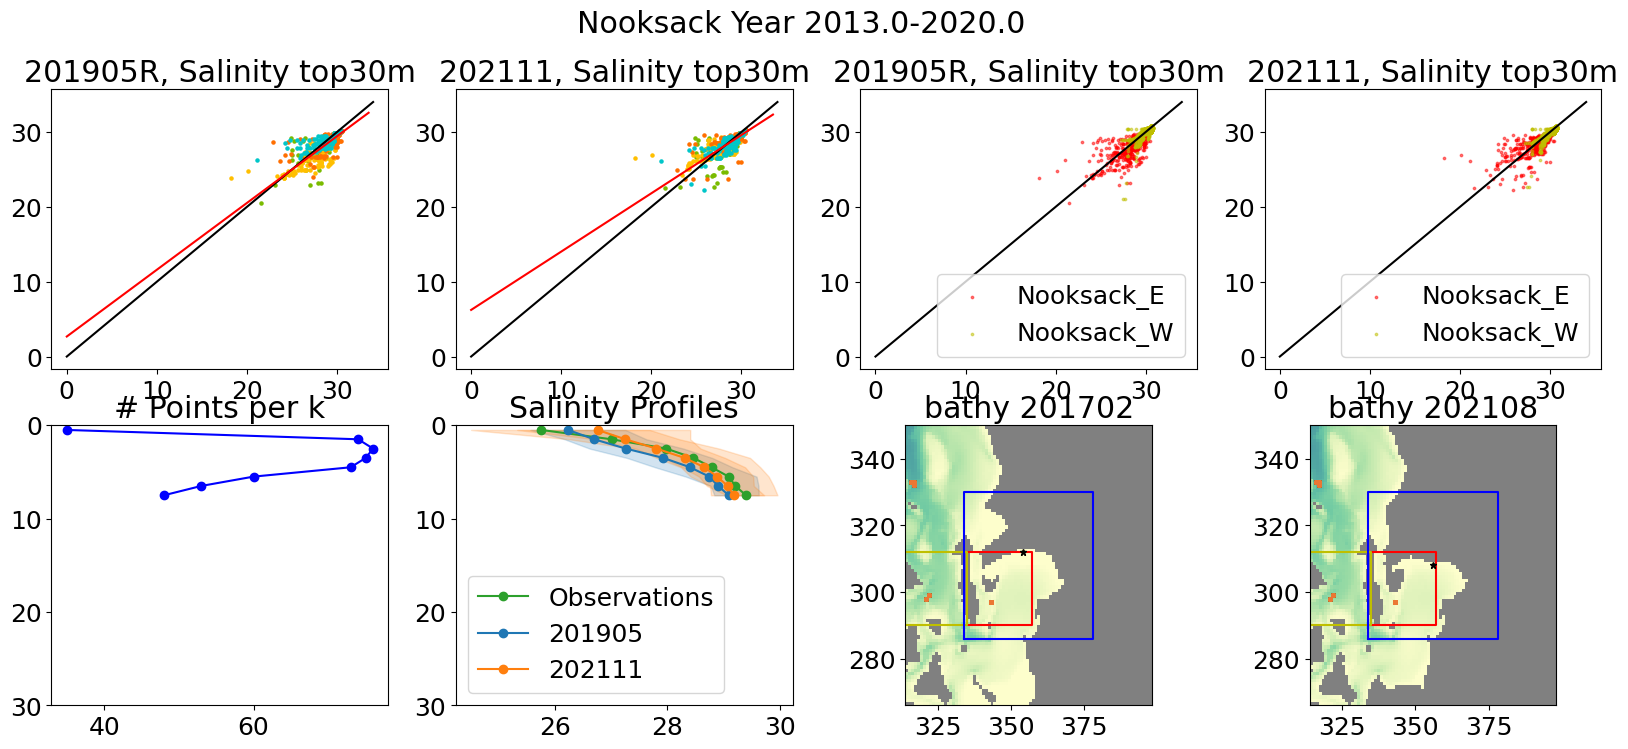

In [173]:
idepth = 0
jdepth = 30
region = 'Nooksack'
boxcall = Nooksack
polys_sub = [Nooksack_E, Nooksack_W]
polynames_sub = ['Nooksack_E', 'Nooksack_W']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

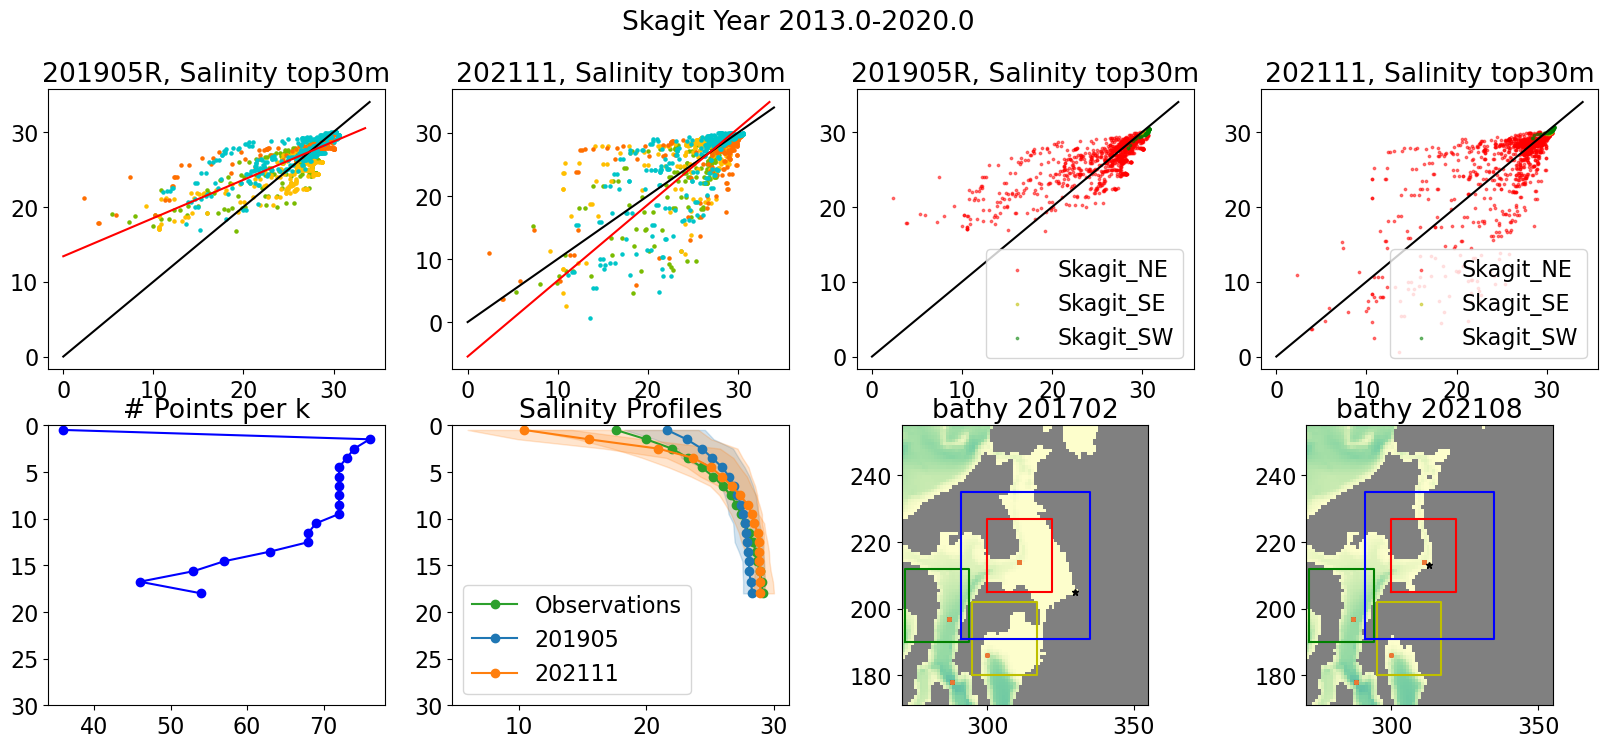

In [179]:
idepth = 0
jdepth = 30
region = 'Skagit'
boxcall = Skagit
polys_sub = [Skagit_NE, Skagit_SE, Skagit_SW]
polynames_sub = ['Skagit_NE', 'Skagit_SE', 'Skagit_SW']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

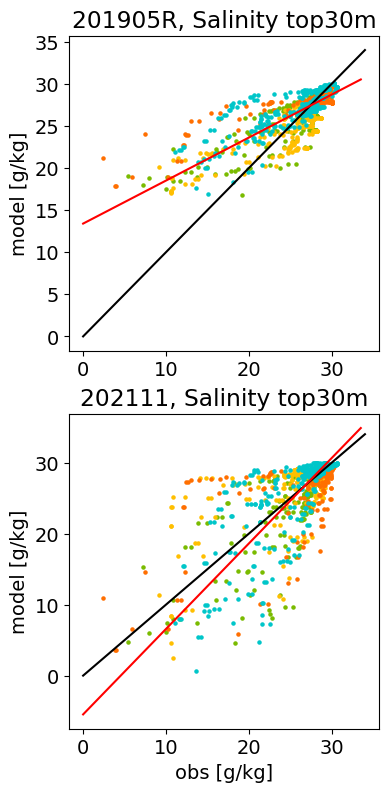

In [190]:
do_scatter_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m')

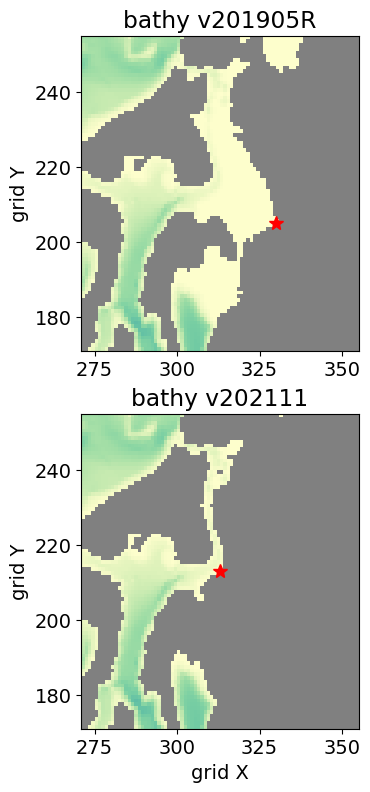

In [198]:
do_bathy_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m')

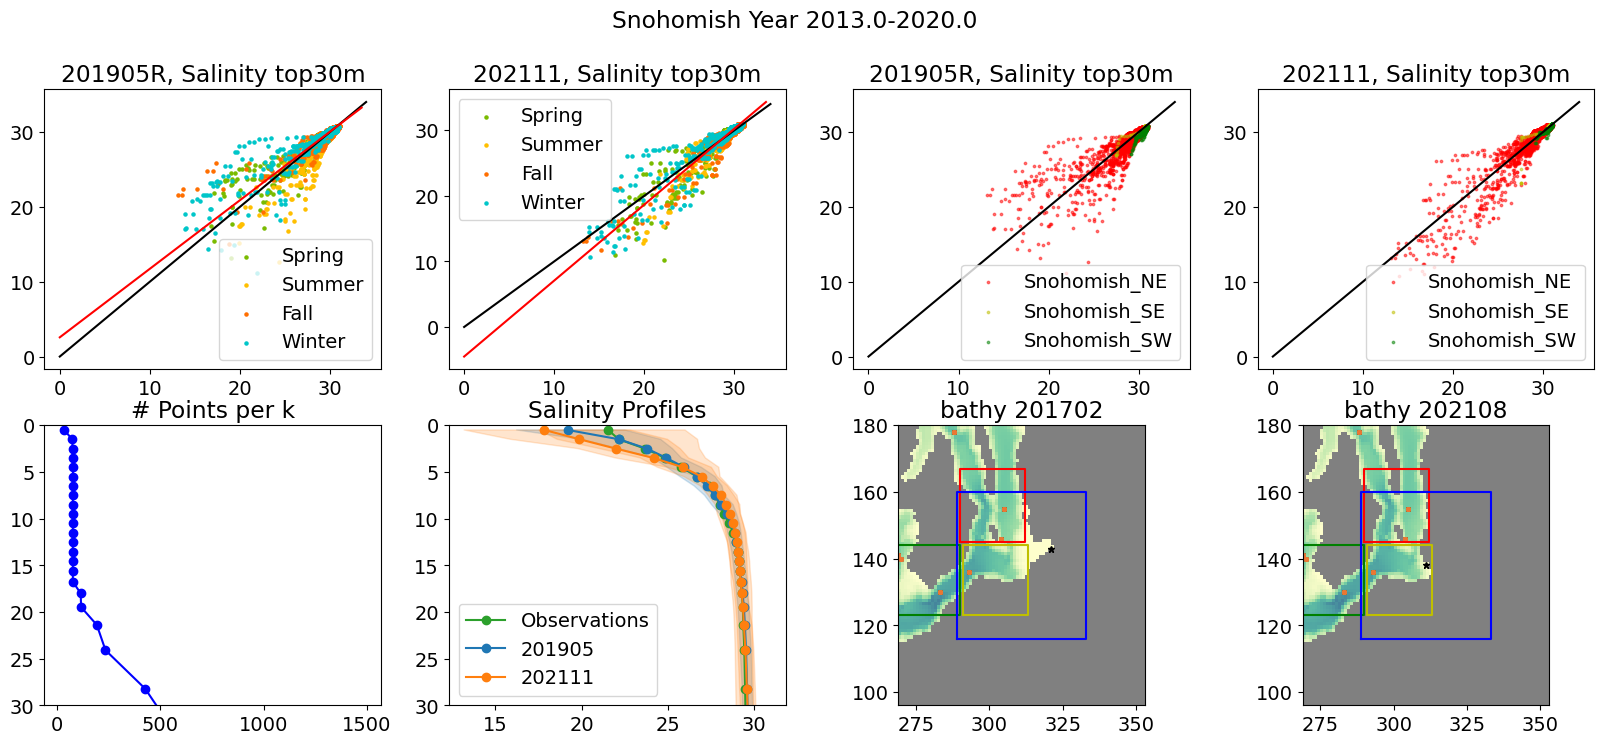

In [151]:
idepth = 0
jdepth = 30
region = 'Snohomish'
boxcall = Snohomish
polys_sub = [Snohomish_NE, Snohomish_SE, Snohomish_SW]
polynames_sub = ['Snohomish_NE', 'Snohomish_SE', 'Snohomish_SW']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

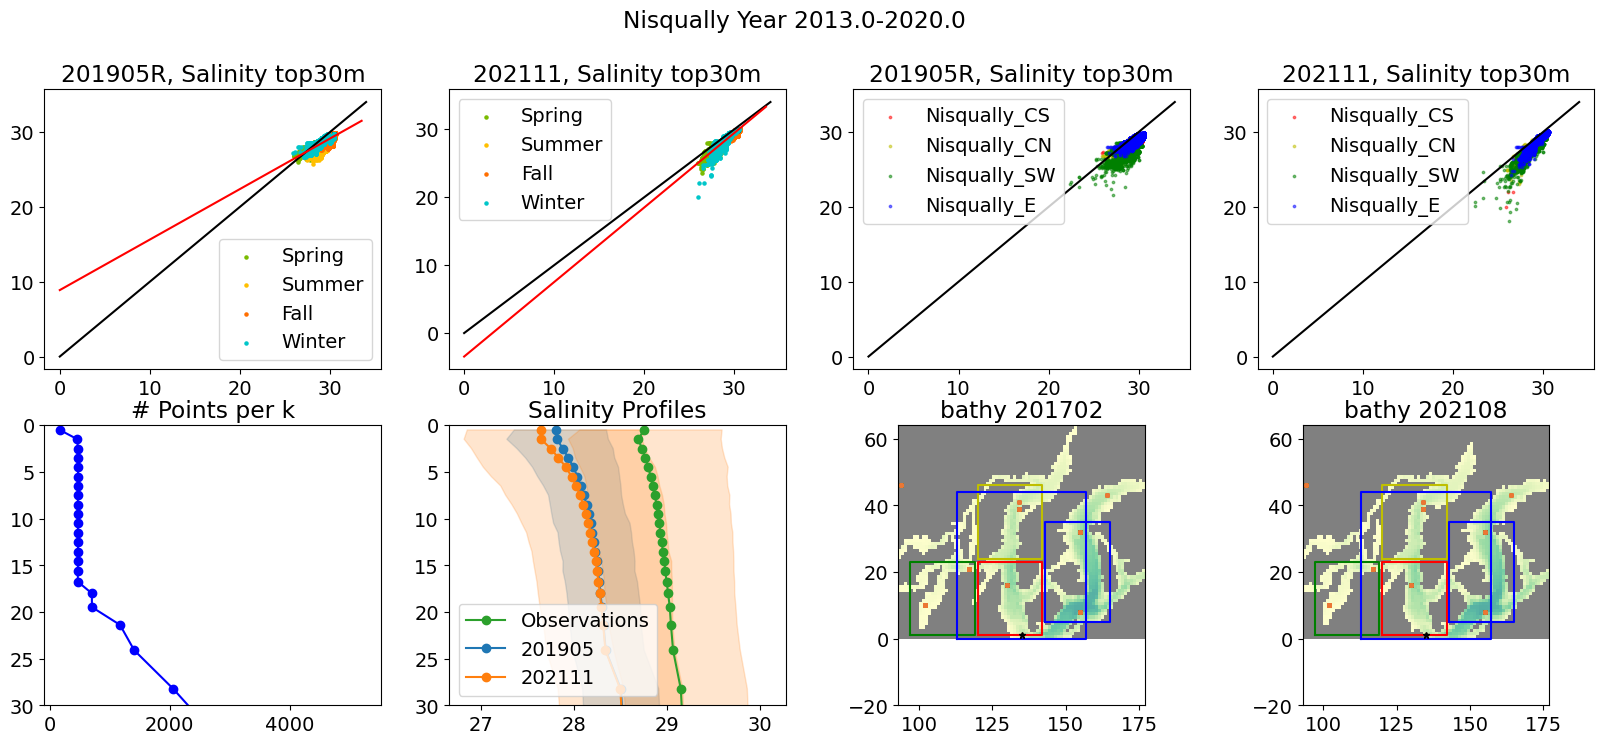

In [152]:
idepth = 0
jdepth = 30
region = 'Nisqually'
boxcall = Nisqually
polys_sub = [Nisqually_CS, Nisqually_CN, Nisqually_SW, Nisqually_E]
polynames_sub = ['Nisqually_CS', 'Nisqually_CN', 'Nisqually_SW', 'Nisqually_E']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

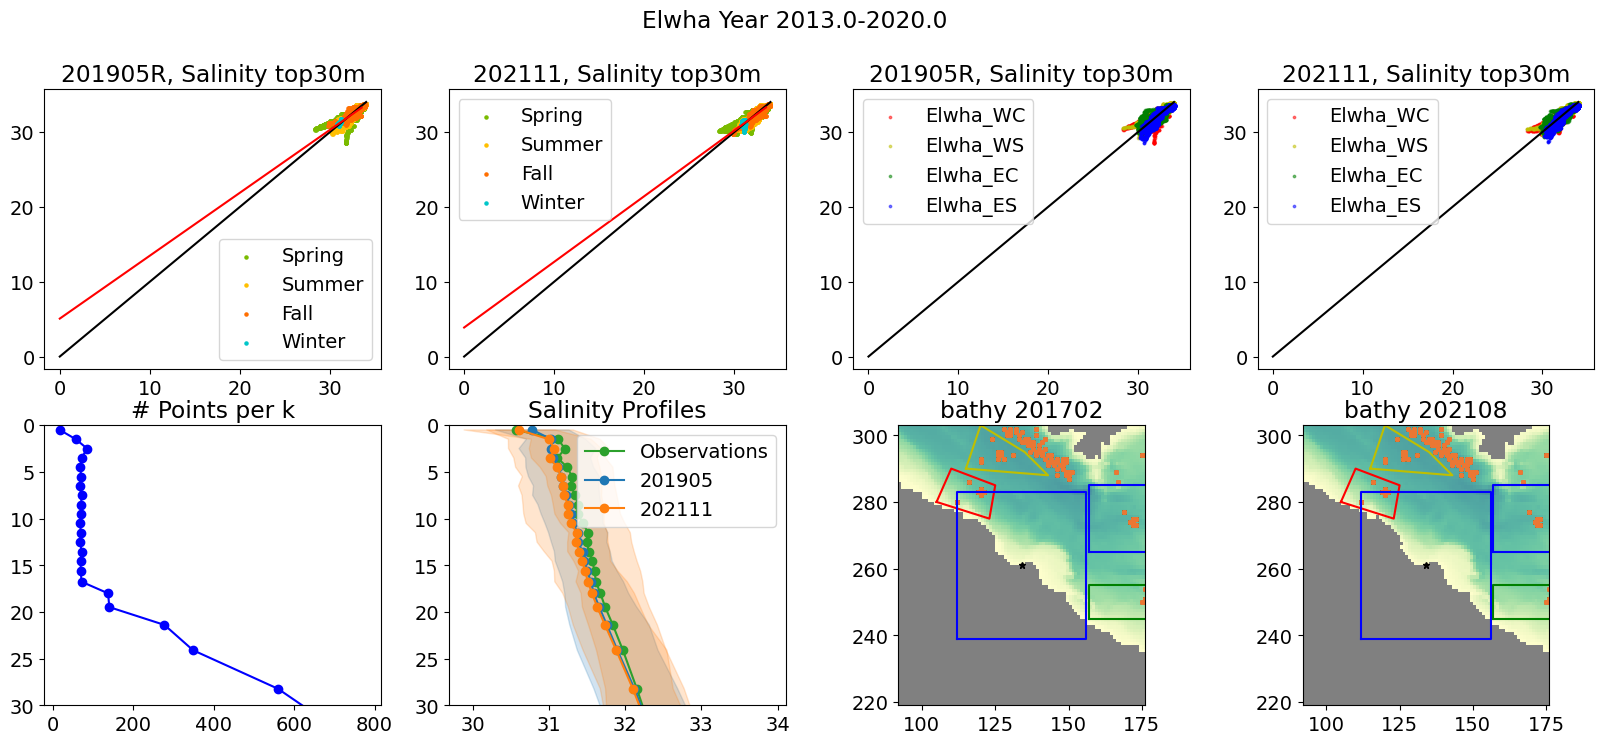

In [153]:
idepth = 0
jdepth = 30
region = 'Elwha'
boxcall = Elwha
polys_sub = [Elwha_WC, Elwha_WS, Elwha_EC, Elwha_ES]
polynames_sub = ['Elwha_WC', 'Elwha_WS', 'Elwha_EC', 'Elwha_ES']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

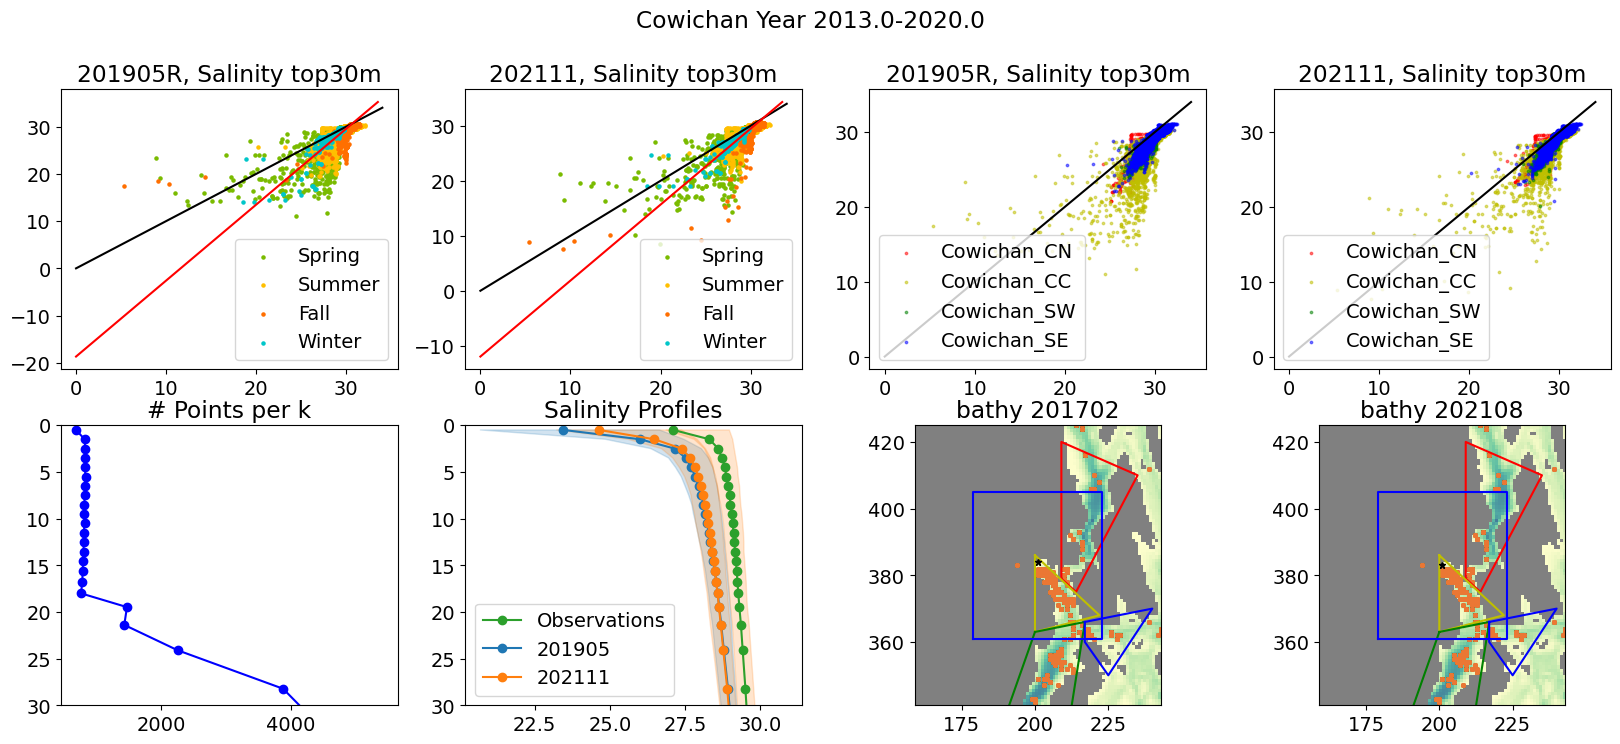

In [154]:
idepth = 0  # TODO: check, why the heck is there ferry data in the cowichan?
jdepth = 30
region = 'Cowichan'
boxcall = Cowichan
polys_sub = [Cowichan_CN, Cowichan_CC, Cowichan_SW, Cowichan_SE]
polynames_sub = ['Cowichan_CN', 'Cowichan_CC', 'Cowichan_SW', 'Cowichan_SE']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

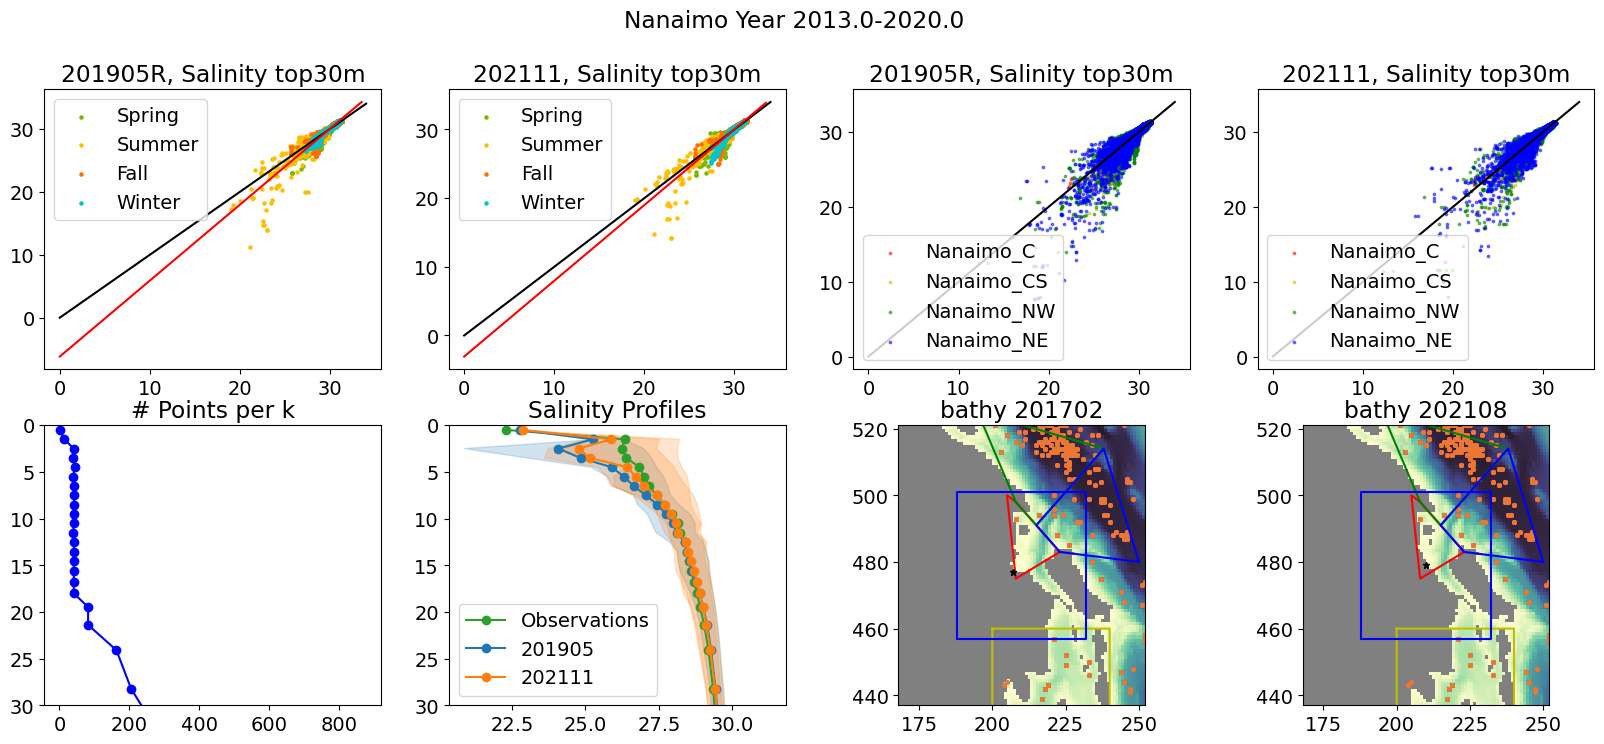

In [155]:
idepth = 0
jdepth = 30
region = 'Nanaimo'
boxcall = Nanaimo
polys_sub = [Nanaimo_C, Nanaimo_CS, Nanaimo_NW, Nanaimo_NE]
polynames_sub = ['Nanaimo_C', 'Nanaimo_CS', 'Nanaimo_NW', 'Nanaimo_NE']
filesave = '8plot_season_region_bathy_nf_' + region + '_noferry.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

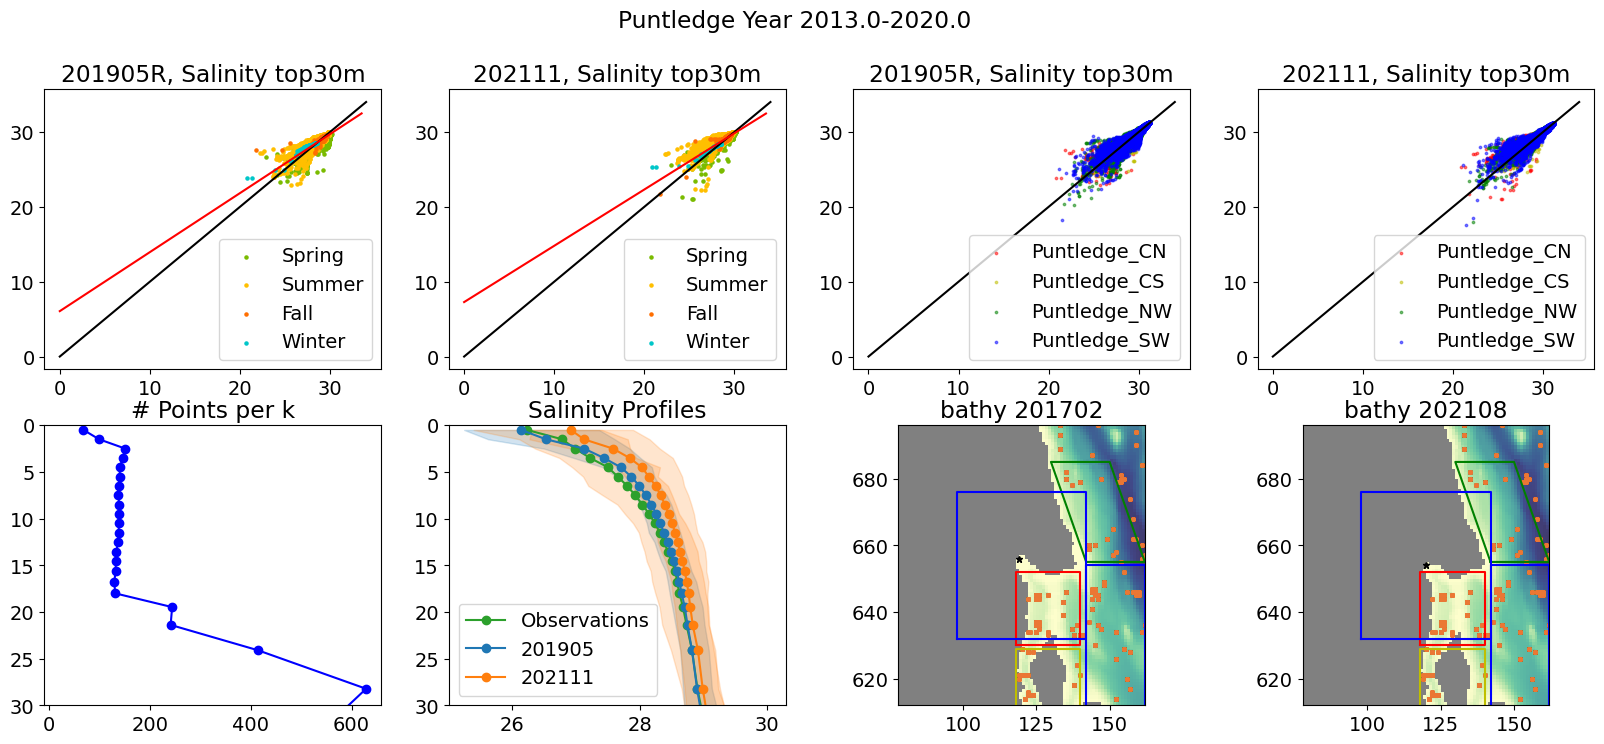

In [156]:
idepth = 0
jdepth = 30
region = 'Puntledge'
boxcall = Puntledge
polys_sub = [Puntledge_CN, Puntledge_CS, Puntledge_NW, Puntledge_SW]
polynames_sub = ['Puntledge_CN', 'Puntledge_CS', 'Puntledge_NW', 'Puntledge_SW']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

In [157]:
Puntledge

[632, 676, 98, 142]

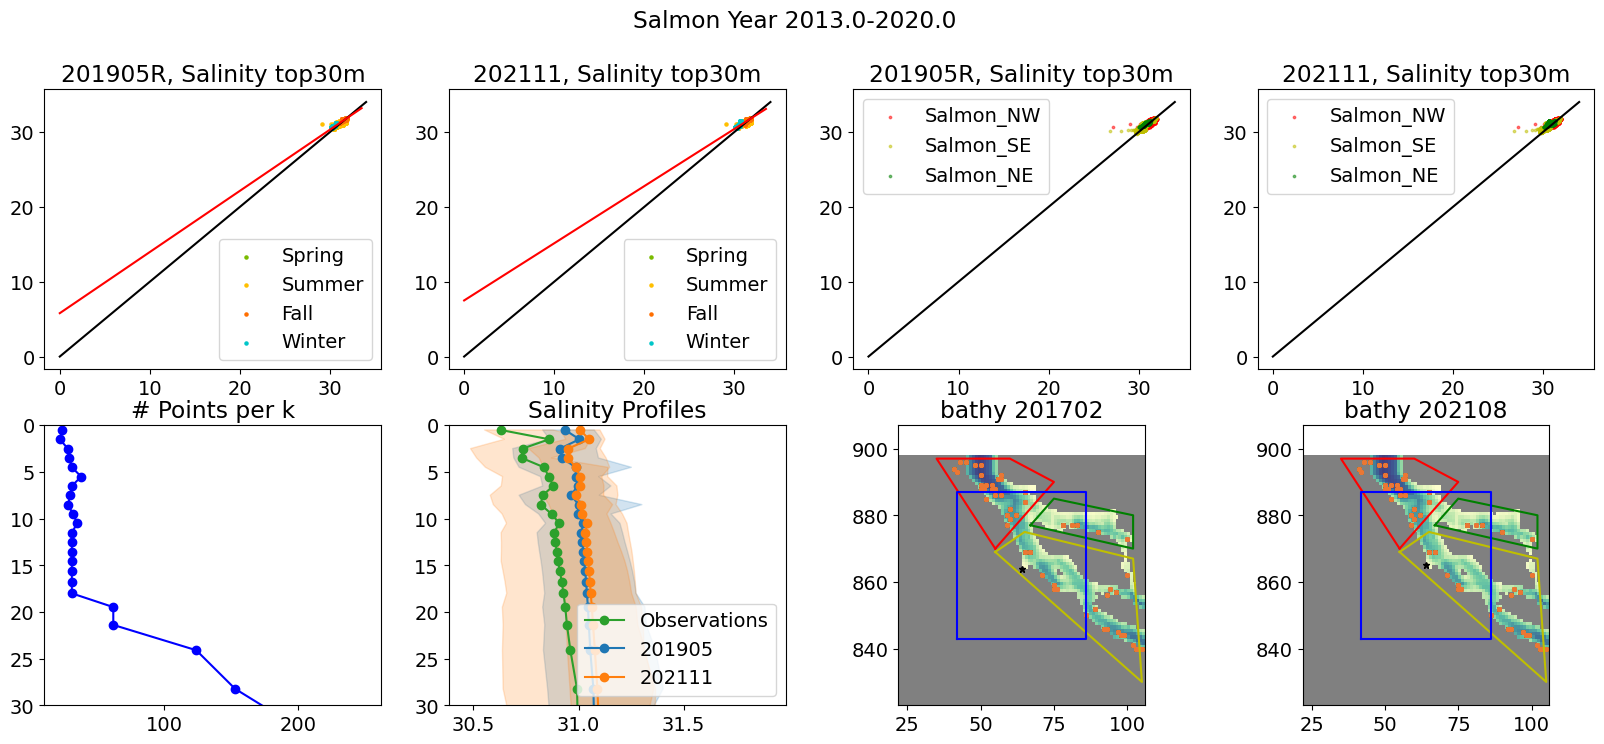

In [158]:
idepth = 0
jdepth = 30
region = 'Salmon'
boxcall = Salmon
polys_sub = [Salmon_NW, Salmon_SE, Salmon_NE]
polynames_sub = ['Salmon_NW', 'Salmon_SE', 'Salmon_NE']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

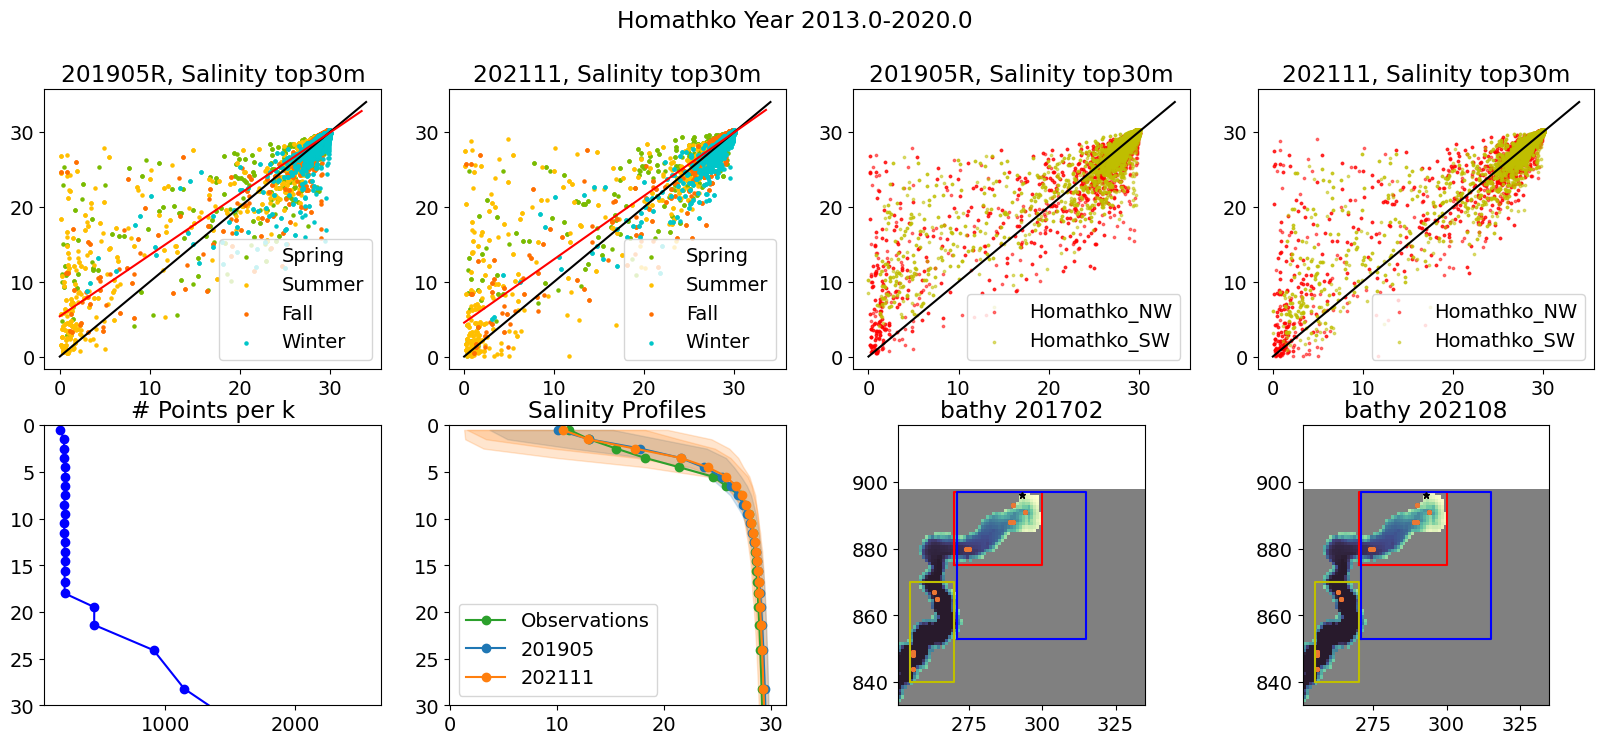

In [159]:
idepth = 0
jdepth = 30
region = 'Homathko'
boxcall = Homathko
polys_sub = [Homathko_NW, Homathko_SW]
polynames_sub = ['Homathko_NW', 'Homathko_SW']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

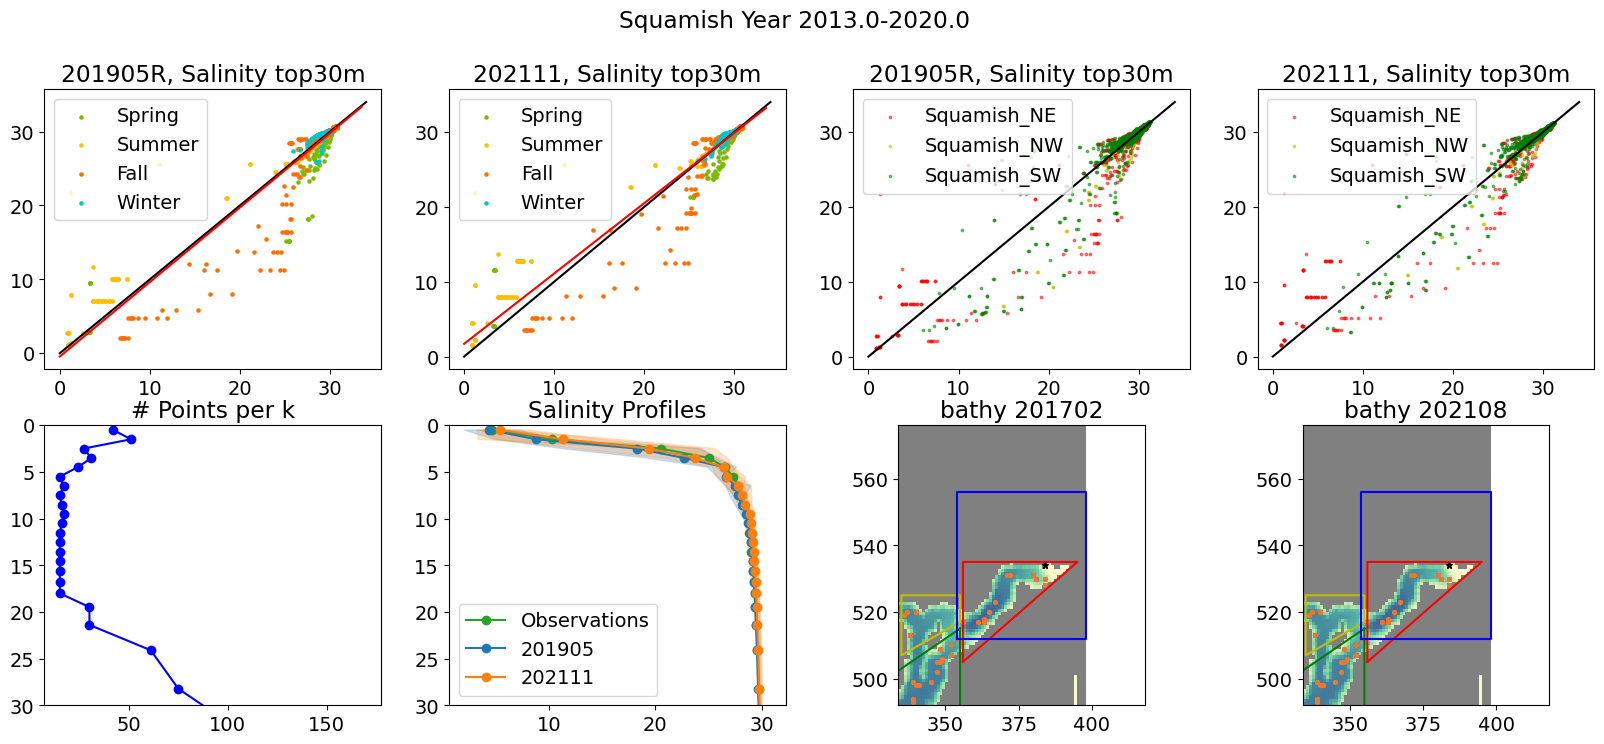

In [160]:
idepth = 0
jdepth = 30
region = 'Squamish'
boxcall = Squamish
polys_sub = [Squamish_NE, Squamish_NW, Squamish_SW]
polynames_sub = ['Squamish_NE', 'Squamish_NW', 'Squamish_SW']
filesave = '8plot_season_region_bathy_nf_' + region + '.png'

do_the_plots(temp1, temp2, idepth, jdepth, boxcall, region, polys_sub, polynames_sub, 'top30m', save_true, filesave)

(350.0, 550.0)

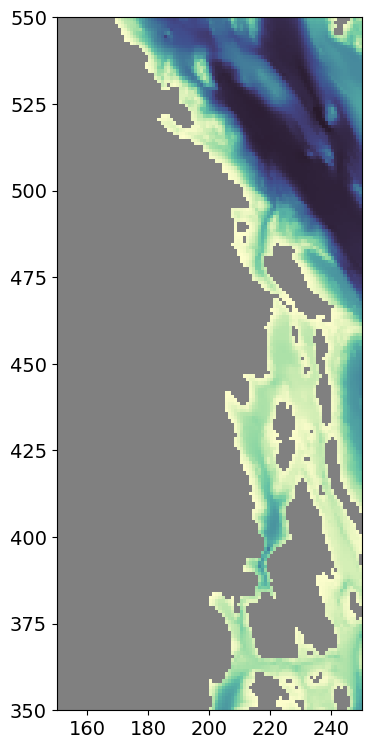

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))

mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

# ax.scatter(temp1[temp1['polygon'] == 'Cowichan_SE']['i'], temp1[temp1['polygon'] == 'Cowichan_SE']['j'], s=5, color='#eb7734')

ax.set_xlim([150, 250])
ax.set_ylim([350, 550])

# colors = ['r', 'y', 'g', 'b']
# for idx in range(len(polys)):
#     plot_poly(ax, polys[idx], colors[idx])


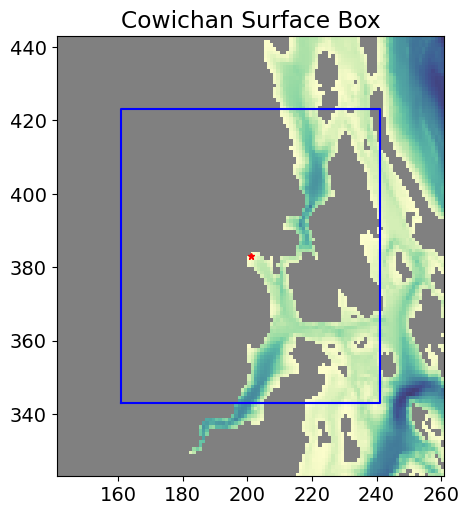

In [162]:
Cowichan_prop = river_box('evi_s', 'Cowichan1', 40)

fig, ax = plt.subplots(1, 1, figsize=(5, 9))

point = river_point(river_dict['Cowichan']['wshed'], river_dict['Cowichan']['call'], old=False)
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
plot_box(ax, Cowichan_prop, 'b')
ax.set_xlim(161-20, 241+20)
ax.set_ylim(343-20, 423+20)
ax.plot(point[1], point[0], 'r*', markersize=5)
ax.set_title('Cowichan Surface Box')
viz_tools.set_aspect(ax);

In [163]:
Puntledge

[632, 676, 98, 142]

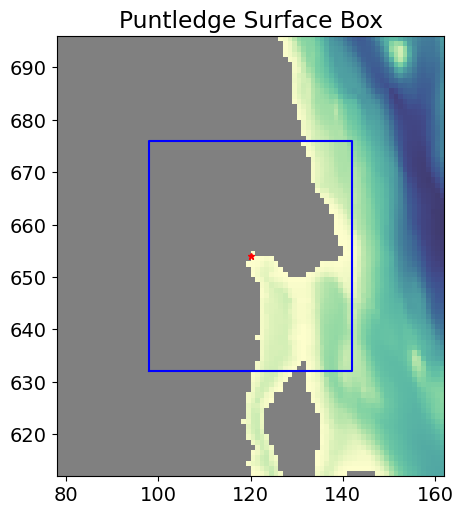

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))

point = river_point(river_dict['Puntledge']['wshed'], river_dict['Puntledge']['call'], old=False)
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
plot_box(ax, Puntledge, 'b')
ax.set_xlim(Puntledge[2]-20, Puntledge[3]+20)
ax.set_ylim(Puntledge[0]-20, Puntledge[1]+20)
ax.plot(point[1], point[0], 'r*', markersize=5)
ax.set_title('Puntledge Surface Box')
viz_tools.set_aspect(ax);

## Looking at more stats

In [165]:
def stats_allregions(temp1, temp2, years, years_psf, years_pug, years_onc, years_ferry, years_cioos, idepth, jdepth, whichdepths):
    # pieces1 = []
    # for year in years:
    #     pieces1.append(
    #           f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
    #          )
    # for year in years_psf:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_cioos:
    #     if (year == 2023):
    #         pieces1.append(
    #             f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
    #     else: 
    #         pieces1.append(
    #             f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    # # for year in years_ferry:
    # #     pieces1.append(
    # #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    # temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    # pieces2 = []
    # for year in years:
    #     pieces2.append(
    #           f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
    #          )
    # for year in years_psf:
    #     pieces2.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces2.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces2.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    # for year in years_cioos:
    #     if (year == 2023):
    #         pieces2.append(
    #             f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
    #     else: 
    #         pieces2.append(
    #             f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # # for year in years_ferry:
    # #     pieces2.append(
    # #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    # temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(filter_bad_data(temp2), '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    # f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lccccccccccl', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    # f.close()
    return alltogether

### Seasons

In [166]:
v201905_winter = temp1[temp1['season'] == 'Winter']
v202111_winter = temp2[temp2['season'] == 'Winter']

idepth = 0
jdepth = 30

results_winter = stats_allregions(v201905_winter, v202111_winter, [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
                           idepth, jdepth, 'top30m')

for boxname in boxnames:
    if results_winter[results_winter.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results_winter[results_winter.region == boxname].loc[:, results_winter.columns != 'region'].style.format(myformat).apply(highlight_max_min))

results_winter.to_csv('results_' + str(idepth) + '_' + str(jdepth) + '_winter_noferry.csv')

Nooksack


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,120,0.238,1.17,1.15,0.293,0.599,17.2,0.91,0.618,0.712
202111,120,-0.0943,1.02,1.02,0.158,0.197,5.5,0.304,0.891,0.269


Skagit


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,317,1.64,3.38,2.96,0.225,0.525,15.0,2.89,1.49,0.706
202111,317,-0.133,4.08,4.08,0.156,-0.527,-13.5,2.39,4.6,-0.919


Snohomish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1677,0.353,1.11,1.05,0.0694,0.206,6.35,0.602,0.848,0.341
202111,1677,0.296,0.959,0.912,0.0394,-0.0751,-1.89,0.346,0.93,-0.145


Nisqually


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,9030,-0.263,0.404,0.306,0.119,0.182,5.03,0.288,0.261,0.298
202111,9030,-0.478,0.578,0.326,0.142,-0.348,-10.6,0.526,0.294,-0.755


Elwha


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,96,0.197,0.261,0.172,0.357,-0.92,-28.3,0.242,0.201,-1.7
202111,96,-0.0208,0.516,0.515,0.852,0.936,29.0,0.145,0.468,-8.3


Cowichan


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1309,-0.352,0.988,0.923,0.161,-0.87,-25.3,0.875,0.872,-2.0
202111,1309,-0.621,0.811,0.521,0.143,-0.292,-9.0,0.677,0.527,-0.587


Nanaimo


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,638,0.0531,0.285,0.28,0.0218,-0.185,-5.53,0.173,0.251,-0.39
202111,638,-0.0361,0.359,0.357,0.0315,-0.292,-8.88,0.263,0.288,-0.644


Puntledge


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,78,0.454,0.668,0.491,0.0783,0.3,8.7,0.612,0.237,0.499
202111,78,0.308,0.746,0.68,0.121,0.45,12.7,0.689,0.244,0.681


Salmon


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,314,0.397,0.405,0.0821,0.434,-0.108,-2.89,0.397,0.0842,-0.207
202111,314,0.512,0.542,0.178,0.496,-0.853,-25.5,0.536,0.142,-2.12


Homathko


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2579,-0.181,1.57,1.56,0.101,-0.0707,-2.19,0.253,1.61,-0.118
202111,2579,-0.342,1.24,1.19,0.0628,-0.0203,-0.919,0.345,1.21,-0.0364


Squamish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,144,0.155,0.662,0.643,0.194,-0.176,-5.03,0.205,0.692,-0.25
202111,144,0.199,0.356,0.296,0.052,-0.0625,-1.64,0.205,0.301,-0.119


In [167]:
v201905_spring = temp1[temp1['season'] == 'Spring']
v202111_spring = temp2[temp2['season'] == 'Spring']

idepth = 0
jdepth = 30

results_spring = stats_allregions(v201905_spring, v202111_spring, [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
                           idepth, jdepth, 'top30m')

for boxname in boxnames:
    if results_spring[results_spring.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results_spring[results_spring.region == boxname].loc[:, results_spring.columns != 'region'].style.format(myformat).apply(highlight_max_min))

results_spring.to_csv('results_' + str(idepth) + '_' + str(jdepth) + '_spring_noferry.csv')

Nooksack


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,134,-0.387,1.21,1.15,0.189,-0.143,-4.44,0.436,1.22,-0.204
202111,134,-0.395,1.31,1.25,0.222,-0.193,-5.87,0.478,1.35,-0.259


Skagit


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,271,0.678,2.73,2.65,0.153,0.414,11.2,1.93,1.66,0.587
202111,271,-0.825,3.65,3.56,0.144,-0.396,-10.9,1.91,3.94,-0.687


Snohomish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1849,0.475,0.859,0.716,0.0791,0.0344,1.46,0.478,0.702,0.0606
202111,1849,0.35,0.89,0.818,0.0613,-0.338,-9.33,0.636,0.757,-0.724


Nisqually


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,9604,-0.199,0.371,0.313,0.202,0.046,1.11,0.2,0.306,0.0532
202111,9604,-0.619,0.676,0.273,0.316,-0.394,-11.8,0.641,0.273,-0.819


Elwha


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1534,0.069,0.822,0.819,0.145,0.321,10.2,0.422,0.619,0.476
202111,1534,0.0918,0.639,0.632,0.0818,0.263,8.45,0.354,0.475,0.448


Cowichan


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,17928,-0.598,1.1,0.926,0.252,-0.86,-25.7,0.947,1.06,-1.81
202111,17928,-0.595,0.921,0.703,0.206,-0.47,-14.3,0.718,0.769,-1.14


Nanaimo


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2021,0.0695,0.36,0.353,0.0384,-0.184,-5.47,0.173,0.349,-0.375
202111,2021,0.0463,0.31,0.307,0.0302,-0.118,-3.49,0.111,0.308,-0.235


Puntledge


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2197,-0.13,0.575,0.56,0.133,0.143,3.95,0.179,0.511,0.212
202111,2197,0.0335,0.443,0.442,0.0767,0.11,3.19,0.102,0.41,0.183


Salmon


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,209,0.11,0.169,0.129,0.363,0.454,14.1,0.127,0.0952,0.449
202111,209,0.138,0.185,0.122,0.405,0.606,18.8,0.162,0.0747,0.634


Homathko


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3103,0.365,2.17,2.14,0.0893,0.254,7.52,1.13,1.66,0.406
202111,3103,0.411,1.87,1.82,0.0643,0.235,7.04,1.07,1.38,0.394


Squamish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,217,-0.761,2.29,2.16,0.0377,0.0425,0.436,0.804,2.1,0.0781
202111,217,-0.265,1.79,1.77,0.025,0.135,3.52,0.861,1.47,0.243


In [168]:
v201905_summer = temp1[temp1['season'] == 'Summer']
v202111_summer = temp2[temp2['season'] == 'Summer']

idepth = 0
jdepth = 30

results_summer = stats_allregions(v201905_summer, v202111_summer, [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
                           idepth, jdepth, 'top30m')

for boxname in boxnames:
    if results_summer[results_summer.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results_summer[results_summer.region == boxname].loc[:, results_summer.columns != 'region'].style.format(myformat).apply(highlight_max_min))

results_summer.to_csv('results_' + str(idepth) + '_' + str(jdepth) + '_summer_noferry.csv')

Nooksack


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,131,-0.968,1.62,1.3,0.212,0.305,7.46,1.13,1.02,0.42
202111,131,0.344,1.37,1.32,0.21,0.492,13.9,1.01,0.778,0.646


Skagit


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,324,-0.32,2.66,2.64,0.137,0.391,9.84,1.77,1.71,0.561
202111,324,0.716,3.74,3.67,0.221,0.13,4.1,0.921,3.41,0.162


Snohomish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1874,-0.218,0.92,0.894,0.117,-0.622,-18.4,0.711,0.876,-1.34
202111,1874,0.0423,0.642,0.64,0.0643,-0.401,-11.7,0.438,0.595,-0.865


Nisqually


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,9542,-0.909,1.01,0.436,0.485,0.256,6.55,0.919,0.372,0.3
202111,9542,-0.696,0.723,0.196,0.277,-0.19,-6.22,0.703,0.187,-0.395


Elwha


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1484,-0.201,0.42,0.369,0.0445,-0.0723,-2.56,0.213,0.376,-0.14
202111,1484,-0.216,0.437,0.379,0.0476,-0.0792,-2.8,0.229,0.387,-0.153


Cowichan


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,15202,-0.979,1.18,0.662,0.295,-0.574,-17.9,1.08,0.689,-1.15
202111,15202,-0.907,1.05,0.53,0.263,-0.367,-11.8,0.953,0.547,-0.713


Nanaimo


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2439,0.0287,0.666,0.665,0.0445,-0.268,-7.95,0.382,0.634,-0.561
202111,2439,0.0351,0.506,0.505,0.0294,-0.108,-3.18,0.158,0.509,-0.214


Puntledge


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2040,0.227,0.66,0.619,0.0994,0.206,6.04,0.333,0.52,0.326
202111,2040,0.424,0.805,0.684,0.156,0.31,9.17,0.56,0.509,0.458


Salmon


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1533,0.055,0.209,0.201,0.0762,0.215,6.73,0.107,0.163,0.348
202111,1533,0.0814,0.23,0.215,0.0995,0.292,9.17,0.149,0.155,0.455


Homathko


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,3012,0.928,2.97,2.82,0.0475,0.189,5.82,1.7,2.23,0.336
202111,3012,0.876,3.02,2.89,0.0472,0.147,4.67,1.41,2.49,0.269


Squamish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,327,0.516,2.05,1.98,0.0122,0.101,3.06,1.12,1.63,0.189
202111,327,0.742,2.44,2.33,0.0182,0.149,4.5,1.64,1.69,0.271


In [169]:
v201905_fall = temp1[temp1['season'] == 'Fall']
v202111_fall = temp2[temp2['season'] == 'Fall']

idepth = 0
jdepth = 30

results_fall = stats_allregions(v201905_fall, v202111_fall, [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
                           idepth, jdepth, 'top30m')

for boxname in boxnames:
    if results_fall[results_fall.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results_fall[results_fall.region == boxname].loc[:, results_fall.columns != 'region'].style.format(myformat).apply(highlight_max_min))

results_fall.to_csv('results_' + str(idepth) + '_' + str(jdepth) + '_fall_noferry.csv')

Nooksack


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,108,-0.311,1.31,1.27,0.244,0.24,6.62,0.484,1.1,0.288
202111,108,0.0667,1.24,1.24,0.207,0.18,5.28,0.287,1.11,0.227


Skagit


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,257,0.743,3.69,3.62,0.275,0.665,18.9,3.55,0.858,0.866
202111,257,-0.594,4.04,4.0,0.185,0.108,2.36,0.82,3.76,0.145


Snohomish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2006,-0.151,0.679,0.662,0.0784,0.238,7.01,0.364,0.517,0.379
202111,2006,-0.0909,0.537,0.53,0.032,-0.191,-5.83,0.281,0.508,-0.408


Nisqually


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,9642,-1.04,1.08,0.278,0.61,-0.353,-11.7,1.05,0.313,-0.544
202111,9642,-0.662,0.678,0.149,0.429,-0.221,-7.33,0.665,0.148,-0.449


Elwha


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1710,-0.108,0.373,0.357,0.0634,0.111,3.52,0.14,0.328,0.189
202111,1710,-0.141,0.331,0.3,0.0445,0.00465,0.0106,0.141,0.299,0.00861


Cowichan


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,5593,-0.686,0.9,0.583,0.295,-0.259,-8.49,0.711,0.638,-0.409
202111,5593,-0.625,0.894,0.639,0.233,-0.613,-19.1,0.767,0.683,-1.21


Nanaimo


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2479,0.103,0.299,0.28,0.0316,-0.078,-2.27,0.121,0.284,-0.153
202111,2479,0.0633,0.285,0.278,0.0301,-0.0321,-0.915,0.0685,0.281,-0.0615


Puntledge


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,303,0.0416,0.457,0.455,0.207,0.445,13.0,0.293,0.298,0.581
202111,303,0.156,0.333,0.294,0.0716,0.0668,2.1,0.162,0.281,0.116


Salmon


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,591,0.135,0.183,0.124,0.276,0.356,11.4,0.149,0.0924,0.473
202111,591,0.128,0.182,0.129,0.249,0.17,5.48,0.132,0.117,0.231


Homathko


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2388,0.271,2.17,2.15,0.0708,0.122,3.7,0.607,1.96,0.19
202111,2388,0.319,1.87,1.84,0.0507,0.1,3.13,0.548,1.7,0.154


Squamish


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,663,-0.453,2.05,1.99,0.0518,-0.401,-12.1,1.6,1.62,-0.905
202111,663,-0.283,1.61,1.58,0.0349,-0.287,-8.63,1.13,1.35,-0.625


### Sub-regions

In [170]:
v201905_subregional = temp1[temp1['polygon'] != 'udt']
v201905_subregional

,Unnamed: 0.1,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,...,depth (m),conservative temperature (oC),index,TEMPS901,SA.1,dtUTCfix,datetime,polygon,season,diff
763,763,763,2013.0,2,6.0,3.541111,48.593333,-123.500333,1.983102,29.537522,...,NaN,NaN,NaN,NaN,NaN,2013-02-06 03:32:28,2013-02-06 03:32:28,Cowichan_SW,Winter,-3.011458
764,764,764,2013.0,2,6.0,3.541111,48.593333,-123.500333,2.974646,29.553252,...,NaN,NaN,NaN,NaN,NaN,2013-02-06 03:32:28,2013-02-06 03:32:28,Cowichan_SW,Winter,-1.775542
765,765,765,2013.0,2,6.0,3.541111,48.593333,-123.500333,3.966186,29.559335,...,NaN,NaN,NaN,NaN,NaN,2013-02-06 03:32:28,2013-02-06 03:32:28,Cowichan_SW,Winter,-1.087646
766,766,766,2013.0,2,6.0,3.541111,48.593333,-123.500333,4.957720,29.546126,...,NaN,NaN,NaN,NaN,NaN,2013-02-06 03:32:28,2013-02-06 03:32:28,Cowichan_SW,Winter,-0.930746
767,767,767,2013.0,2,6.0,3.541111,48.593333,-123.500333,5.949249,29.528596,...,NaN,NaN,NaN,NaN,NaN,2013-02-06 03:32:28,2013-02-06 03:32:28,Cowichan_SW,Winter,-0.886342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177187,2177187,3671,NaN,7,NaN,NaN,50.677691,-124.888827,45.521589,29.391137,...,NaN,NaN,NaN,8.990557,29.532859,2023-07-20 18:41:35,2023-07-20 18:41:35,Homathko_SW,Summer,0.152516
2177188,2177188,3672,NaN,7,NaN,NaN,50.677691,-124.888827,46.493907,29.399350,...,NaN,NaN,NaN,8.973283,29.541105,2023-07-20 18:41:35,2023-07-20 18:41:35,Homathko_SW,Summer,0.144303
2177189,2177189,3673,NaN,7,NaN,NaN,50.677691,-124.888827,47.589847,29.423753,...,NaN,NaN,NaN,8.943720,29.565619,2023-07-20 18:41:35,2023-07-20 18:41:35,Homathko_SW,Summer,0.119900
2177190,2177190,3674,NaN,7,NaN,NaN,50.677691,-124.888827,48.667570,29.436744,...,NaN,NaN,NaN,8.921087,29.578666,2023-07-20 18:41:35,2023-07-20 18:41:35,Homathko_SW,Summer,0.106909
